# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

**Основные шаги**:
1. Загрузить данные, путь к файлу: /datasets/autos.csv.
2. Изучить данные. Заполнить пропущенные значения и обработать аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их.
3. Подготовить выборки для обучения моделей.
4. Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры.
5. Проанализировать время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.

**Примечания**:
- Для оценки качества моделей будет применяться метрика RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Модель LightGBM будет построена с помощью градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook нужно будет сравнить для разных моделей.
- Модель градиентного бустинга может долго обучаться, поэтому изменять у неё рекомендовано два-три параметра.
- Если перестанет работать Jupyter Notebook, рекомендовано удалить лишние переменные оператором del.

## Подготовка данных

### Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import sklearn

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgbm

pd.set_option('display.float_format', lambda x: '%.2f' % x)
import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE=12345

### Загрузка данных

In [2]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('/Users/vadimprimakov/Documents/Yandex_practicum/CSV/13_gradient_boosting_autos.csv')
    
display(data.head()) 

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
display(data.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
Price,354369.00,4416.66,4514.16,0.00,1050.00,2700.00,6400.00,20000.00
RegistrationYear,354369.00,2004.23,90.23,1000.00,1999.00,2003.00,2008.00,9999.00
Power,354369.00,110.09,189.85,0.00,69.00,105.00,143.00,20000.00
Kilometer,354369.00,128211.17,37905.34,5000.00,125000.00,150000.00,150000.00,150000.00
RegistrationMonth,354369.00,5.71,3.73,0.00,3.00,6.00,9.00,12.00
NumberOfPictures,354369.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
PostalCode,354369.00,50508.69,25783.10,1067.00,30165.00,49413.00,71083.00,99998.00


По первому взгляду на имеющийся датасет, можно отметить, что не все признаки будут информативны для нашей цели - определение рыночной стоимости автомобиля, например, дата скачивания анкеты из базы, дата создания анкеты, почтовый индекс владельца анкеты (пользователя) и дата последней активности пользователя. Также наличие фотографий может влиять на скорость продажи машины, но не на ее рыночную стоимость. Эти признаки можно удалить.

В данных есть много пропущенный значений. Если для библиотеки CatBoost это не проблема, для неё они — это отдельная категория, а вот для более простых моделей все равно потребуется обработка.

В данных есть выбросы, например, у лошадинных сил и года регистрации. Нужно будет попытаться определить, что означает нулевой месяц регистрации, также потребуется проверка на дубликаты.

### Предобработка данных

#### Проверка на дубликаты

Проведем проверку на дубликаты. Дублирующиеся записи, при наличии исключим из исследования.

In [5]:
display(data.duplicated().sum())

4

In [6]:
data = data.drop_duplicates()

#### Целевой признак - Price — цена (евро)

Исследуем аномальные значения в целевом признаке.

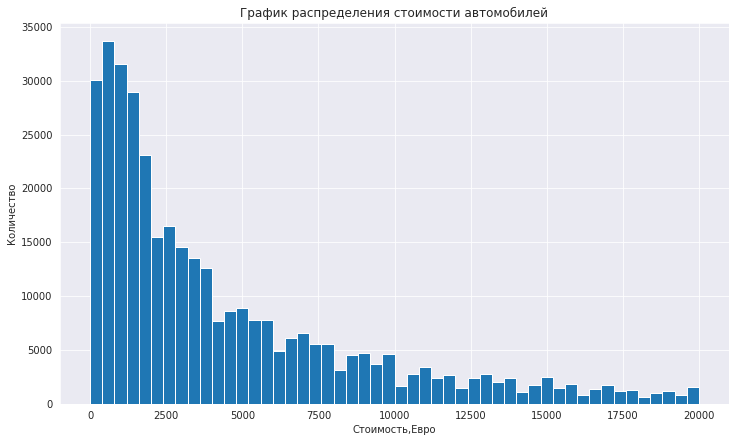

In [7]:
sns.set_style('darkgrid')
data.Price.hist(bins=50,figsize=(12,7))
plt.title('График распределения стоимости автомобилей')
plt.xlabel('Стоимость,Евро')
plt.ylabel('Количество')
plt.show()

In [8]:
data.loc[data['Price'] < 10]['Price'].count()

12028

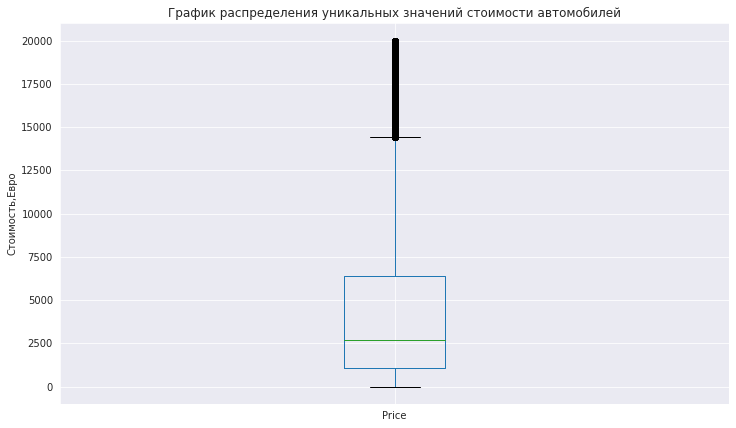

In [9]:
data.boxplot(['Price'],figsize=(12,7))
plt.title('График распределения уникальных значений стоимости автомобилей')

plt.ylabel('Стоимость,Евро')
plt.show()

На графиках видно, что существуют автомобили, стоимостью ниже 10€, такие значения не информативны. так как скорее всего владельцы могут указывать такую цену только за разбитый автомобиль, либо с расчётом на равноценный обмен, что точно не отражает реальную рыночную стоимость. Такие значения будут удалены.

In [10]:
data = data.query('Price > 10')

In [11]:
data.loc[data['Price'] < 10]['Price'].count()

0

#### RegistrationYear — год регистрации автомобиля

In [12]:
data.RegistrationYear.unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 5000, 1958, 1967, 1956, 3200,
       1000, 1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940,
       3000, 2066, 1949, 2019, 1937, 1951, 1800, 1959, 1953, 1954, 1234,
       8000, 5300, 9000, 2900, 6000, 5900, 5911, 1400, 1950, 4000, 1948,
       1952, 8500, 1932, 1255, 3700, 3800, 4800, 1942, 7000, 1935, 1933,
       1936, 1923, 2290, 1930, 1001, 9450, 1944, 2500, 1943, 1938, 1934,
       1928, 5555, 5600, 1600, 1111, 2222, 1039, 1300, 2800, 1931, 4500,
       1602, 7800, 1947, 1927, 7100, 8200, 1946])

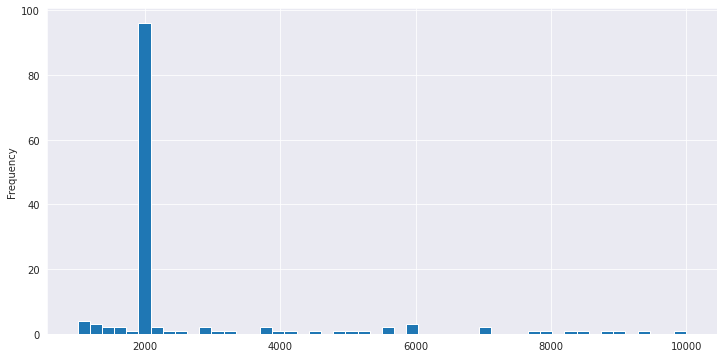

In [13]:
pd.Series(list(data.RegistrationYear.unique())).sort_values(ascending=False).plot(kind='hist', figsize=(12,6), grid=True, bins=50)
plt.show()

Вычислим дату формирования списков автомобилей и отсортируем данные о регистрации по этой дате, дата регистрации автомобилей позже максимальной даты формирования объявления невозможны, а так же удалим совсем старые а/м, которым более 67 лет.

In [14]:
data.DateCrawled.max()

'2016-04-07 14:36:58'

In [15]:
data = data.query('RegistrationYear >= 1950 & RegistrationYear < 2017')

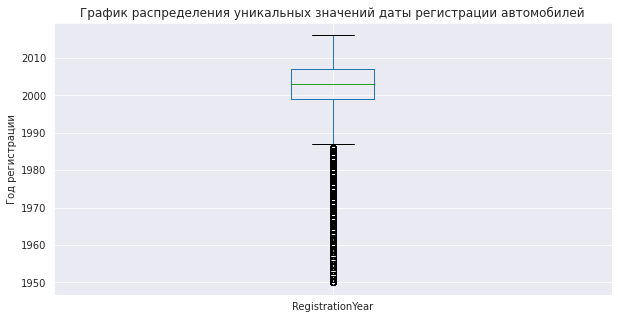

In [16]:
data.boxplot('RegistrationYear', figsize=(10,5))
plt.title('График распределения уникальных значений даты регистрации автомобилей')
plt.ylabel('Год регистрации')
plt.xlabel('')
plt.show()

#### DateCrawled — дата скачивания анкеты из базы

Дата скачивания анкеты была использована, за неинформативностью, она может быть удалена.

In [17]:
del data['DateCrawled']
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


#### VehicleType — тип автомобильного кузова

Посмотрим на отсутствующие значения колонки - тип автомобильного кузова.

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328381 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              328381 non-null  int64 
 1   VehicleType        308953 non-null  object
 2   RegistrationYear   328381 non-null  int64 
 3   Gearbox            313261 non-null  object
 4   Power              328381 non-null  int64 
 5   Model              313066 non-null  object
 6   Kilometer          328381 non-null  int64 
 7   RegistrationMonth  328381 non-null  int64 
 8   FuelType           304742 non-null  object
 9   Brand              328381 non-null  object
 10  Repaired           269267 non-null  object
 11  DateCreated        328381 non-null  object
 12  NumberOfPictures   328381 non-null  int64 
 13  PostalCode         328381 non-null  int64 
 14  LastSeen           328381 non-null  object
dtypes: int64(7), object(8)
memory usage: 40.1+ MB


In [19]:
data['VehicleType'].value_counts()

sedan          89163
small          77809
wagon          63526
bus            28275
convertible    19812
coupe          15565
suv            11756
other           3047
Name: VehicleType, dtype: int64

Отсутствующие значения можно выделить в отдельную категорию 'undefined', либо добавить к категории 'other'.

In [20]:
data['VehicleType'] = data['VehicleType'].fillna('other')

In [21]:
data['VehicleType'].value_counts()

sedan          89163
small          77809
wagon          63526
bus            28275
other          22475
convertible    19812
coupe          15565
suv            11756
Name: VehicleType, dtype: int64

#### Gearbox — тип коробки передач

In [22]:
data.query('Gearbox.isna()')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
16,300,other,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
32,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43
37,1500,other,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
69,1200,coupe,2001,NaN,0,astra,150000,0,NaN,opel,NaN,2016-04-01 00:00:00,0,47249,2016-04-07 08:46:07
92,250,other,2000,NaN,60,ka,150000,0,NaN,ford,NaN,2016-03-16 00:00:00,0,51427,2016-03-21 09:47:08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354288,3300,wagon,2006,NaN,0,touran,150000,7,gasoline,volkswagen,NaN,2016-03-16 00:00:00,0,12057,2016-03-17 12:17:07
354305,3500,other,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-04-03 00:00:00,0,74579,2016-04-05 12:44:38
354329,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,2016-03-30 00:00:00,0,25436,2016-04-07 13:50:41
354338,180,other,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31 00:00:00,0,41470,2016-04-06 14:18:04


Информация о коробкe передач важный параметр для определения цены, который сильно может повлиять на модель при обучении. Восстановление данных проблематично, таких данных менее 5%, в связи с этим лучше избавиться от этих данных нежели заполнить пропуски значением 'undefined'. К тому же по данным строкам есть ошибочные значения и пропуски в других столбцах.

In [23]:
data.dropna(subset=['Gearbox'], inplace=True)

In [24]:
data['Gearbox'].unique()

array(['manual', 'auto'], dtype=object)

#### Power — мощность (л. с.)

Исследуем значения колонки - мощность.

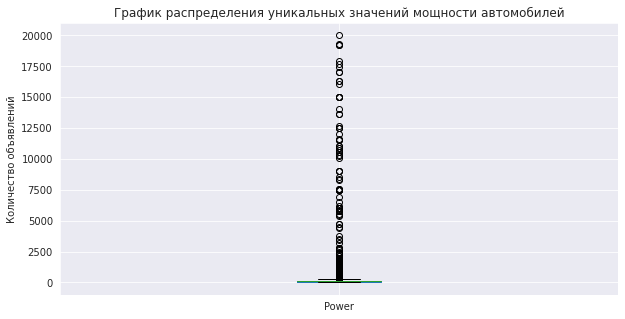

In [25]:
data.boxplot('Power', figsize=(10,5))
plt.title('График распределения уникальных значений мощности автомобилей')
plt.ylabel('Количество объявлений')
plt.xlabel('')
plt.show()

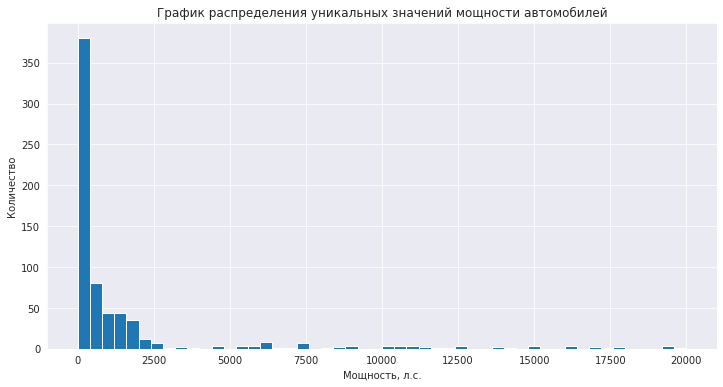

In [26]:
pd.Series(list(data.Power.unique())).sort_values(ascending=False).plot(kind='hist', figsize=(12,6), grid=True, bins=50)
plt.title('График распределения уникальных значений мощности автомобилей')
plt.ylabel('Количество')
plt.xlabel('Мощность, л.с.')
plt.show()

In [27]:
data['Power'].isna().sum()

0

In [28]:
data['Power'].value_counts()

0       22463
75      21558
60      14363
150     13514
101     12190
        ...  
416         1
1079        1
6045        1
671         1
1653        1
Name: Power, Length: 675, dtype: int64

Пропусков нет, однако существуют 22 тычячи нулевых значений, их и можно считать пропусками. Мощность зачастую зависит от модели и года выпуска, а значит можно попробовать заполнить эти данные по уже имеющимся. Если где-то это не получится, данные будут удалены.

In [29]:
def calculate_power(df, brand, model, year):
    data_part = data[(data['RegistrationYear'] == year) & (data['Brand'] == brand) & (data['Model'] == model)]
    if (data_part['Power'].count() == 0):
        data_part = data[(data['Brand'] == brand) & (data['Model'] == model)]
    
    median_power = data_part['Power'].median()
    
    if (math.isnan(median_power)):
        median_power = 0
        
    return median_power

Попробуем заполнить мощность для наших данных, отметки выберем из логических соображений по вероятностью существования таких двигателей.

In [30]:
power_data = data[(data['Power'] < 30) | (data['Power'] > 340)][['Brand', 'Model', 'RegistrationYear']]
power_data.count()

Brand               24577
Model               21851
RegistrationYear    24577
dtype: int64

Количество моделей не совпало, заполним пустые модели категорией 'other'

In [31]:
power_data['Model'] = power_data['Model'].fillna('other')

In [32]:
power_data = power_data.drop_duplicates()
power_data.count()

Brand               3500
Model               3500
RegistrationYear    3500
dtype: int64

In [33]:
%%time

for row in power_data.itertuples(index=True, name='Pandas'):
    year = getattr(row, "RegistrationYear")
    brand = getattr(row, "Brand")
    model = getattr(row, "Model")
    median = calculate_power(data, brand, model, year)
    searchRow = ((data['Power'] < 30) | (data['Power'] > 340)) & (data['Brand'] == brand) & (data['Model'] == model) & (data['RegistrationYear'] == year)
    data.loc[searchRow, 'Power'] = median

CPU times: user 5min 18s, sys: 714 ms, total: 5min 19s
Wall time: 5min 20s


In [34]:
data[data['Power'] == 0]['Price'].count()

2683

Остались только какие-то уникальные модели, которые не встретились в остальной выборке, их можно удалить. Значения больше 340 разделим на 100, меньше 15 домножим на 10.

In [35]:
data = data[data['Power'] != 0]

In [36]:
data.loc[data['Power'] > 340, 'Power'] = data['Power']/100
data.loc[data['Power'] <= 15, 'Power'] = data['Power']*10
data['Power'] = data['Power'].astype('int')

In [37]:
data['Power'].describe()

count   310578.00
mean       118.89
std         51.15
min         10.00
25%         75.00
50%        110.00
75%        147.00
max        340.00
Name: Power, dtype: float64

In [38]:
data.loc[data['Power'] < 10]['Price'].count()

0

#### Model — модель автомобиля

Просмотрим пропущенные значения по столбцу модель автомобиля.

In [39]:
data.query('Model.isna()')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
81,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,2016-04-03 00:00:00,0,45665,2016-04-05 11:47:13
135,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27 00:00:00,0,38709,2016-04-05 20:17:31
193,1200,coupe,1990,manual,45,NaN,150000,0,petrol,volkswagen,NaN,2016-03-27 00:00:00,0,83317,2016-04-07 08:17:08
273,1500,coupe,1994,manual,116,NaN,150000,8,NaN,audi,no,2016-03-29 00:00:00,0,32791,2016-04-06 20:16:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354077,200,small,1998,manual,37,NaN,150000,4,petrol,volkswagen,yes,2016-03-21 00:00:00,0,26382,2016-04-06 02:45:28
354234,5000,sedan,2002,auto,170,NaN,150000,0,petrol,audi,no,2016-03-18 00:00:00,0,85221,2016-04-06 03:45:36
354245,560,small,2001,auto,170,NaN,90000,0,petrol,fiat,yes,2016-03-07 00:00:00,0,55743,2016-03-12 21:45:25
354321,9400,wagon,2007,manual,200,NaN,150000,4,gasoline,sonstige_autos,yes,2016-03-15 00:00:00,0,91186,2016-03-17 08:16:25


In [40]:
data['Model'].value_counts()

golf                  25521
other                 21818
3er                   18076
polo                  11442
corsa                 10966
                      ...  
kalina                    5
serie_2                   5
serie_3                   3
rangerover                2
range_rover_evoque        2
Name: Model, Length: 249, dtype: int64

Модель - это основопологающий фактор, который напрямую воздействует на образование цены, восстановить реальные значения трудно, удалять пустые значения не будем, выделим их в отдельную категорию 'undefined'.

In [41]:
data['Model'] = data['Model'].fillna('undefined')

#### Kilometer — пробег (км)

Исследуем значения в столбце с пробегом автомобиля.

In [42]:
display(data['Kilometer'].describe())

count   310578.00
mean    128618.61
std      36696.89
min       5000.00
25%     125000.00
50%     150000.00
75%     150000.00
max     150000.00
Name: Kilometer, dtype: float64

Каких-либо существенных особенностей не выявлено.

#### RegistrationMonth — месяц регистрации автомобиля

In [43]:
data['RegistrationMonth'].describe()

count   310578.00
mean         5.95
std          3.61
min          0.00
25%          3.00
50%          6.00
75%          9.00
max         12.00
Name: RegistrationMonth, dtype: float64

In [44]:
data['RegistrationMonth'] = data['RegistrationMonth'].astype('int')

In [45]:
data['RegistrationMonth'].value_counts()

3     31650
6     28611
4     26761
5     26609
7     24865
10    23928
12    22115
9     21901
11    21882
0     21222
1     20967
8     20599
2     19468
Name: RegistrationMonth, dtype: int64

In [46]:
data[data['RegistrationMonth'] == 0].head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,480,other,1993,manual,75,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
9,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06
36,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,2016-03-11 00:00:00,0,2943,2016-04-07 03:46:09
54,4700,wagon,2005,manual,155,signum,150000,0,NaN,opel,no,2016-03-17 00:00:00,0,88433,2016-04-04 04:17:32
80,250,wagon,2000,manual,155,156,150000,0,petrol,alfa_romeo,yes,2016-04-01 00:00:00,0,8396,2016-04-05 20:18:14
104,300,convertible,1992,manual,105,escort,150000,0,NaN,ford,yes,2016-03-20 00:00:00,0,88515,2016-04-06 13:15:58
129,300,small,2000,manual,54,corsa,150000,0,petrol,opel,NaN,2016-03-26 00:00:00,0,59379,2016-04-06 09:15:51
135,1450,sedan,1992,manual,136,undefined,150000,0,NaN,audi,no,2016-03-27 00:00:00,0,38709,2016-04-05 20:17:31
143,1500,wagon,1996,manual,126,a4,150000,0,NaN,audi,no,2016-03-14 00:00:00,0,24873,2016-03-17 00:45:29
168,950,sedan,1995,manual,115,5er,150000,0,petrol,bmw,NaN,2016-04-01 00:00:00,0,27751,2016-04-07 07:46:00


Достаточно большое количество данных содержит в графе месяц регистрации нулевой показатель. Не хотелось бы отказываться от этих данных, так как сам признак не кажется существенным, можно было бы заменить его на месяц создания анкеты, но это не отражает действительности, поэтому можно считать, что значение '0' в нашем случае это 'undefined'.

#### FuelType — тип топлива

In [47]:
data['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [48]:
data['FuelType'].isna().sum()

16874

Отсутствующие значения можно выделить в отдельную категорию 'undefined', либо добавить к категории 'other'.

In [49]:
data['FuelType'] = data['FuelType'].fillna('other')

#### Brand — марка автомобиля

In [50]:
data['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'seat', 'honda',
       'fiat', 'opel', 'mini', 'smart', 'hyundai', 'alfa_romeo', 'subaru',
       'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia', 'citroen',
       'toyota', 'chevrolet', 'dacia', 'sonstige_autos', 'daihatsu',
       'chrysler', 'jaguar', 'daewoo', 'rover', 'porsche', 'saab',
       'land_rover', 'trabant', 'lada'], dtype=object)

Каких-либо существенных особенностей не выявлено.

#### Repaired — была машина в ремонте или нет

In [51]:
data['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [52]:
data['Repaired'].isna().sum()

48803

Имеем очень необычную картину, когда нам неизвестно была ли машина в ремонте. Стоит выделить данный факт в отдельную категорию, может оказаться, что ремонт все же был, однако нам неизвестен источник данных. Поэтому в данном случае будет правильно переделать признак в количественный, где 0 будет отсутствие ремонта, 1 ремонт был и 2 - неопределено (таким образом можно будет определить вес каждой категории)

In [53]:
data['Repaired'] = data['Repaired'].fillna(2)

def repair_number(value):
    if value == 'no':
        return 0
    elif value == 'yes':
        return 1
    else:
        return value

data['Repaired'] = data['Repaired'].apply(repair_number)
data['Repaired'].value_counts()

0    230713
2     48803
1     31062
Name: Repaired, dtype: int64

#### DateCreated — дата создания анкеты

In [54]:
data['DateCreated'].describe()

count                  310578
unique                    106
top       2016-04-03 00:00:00
freq                    12151
Name: DateCreated, dtype: object

#### NumberOfPictures — количество фотографий автомобиля

In [55]:
data['NumberOfPictures'].describe()

count   310578.00
mean         0.00
std          0.00
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          0.00
Name: NumberOfPictures, dtype: float64

#### LastSeen — дата последней активности пользователя

In [56]:
data['LastSeen'].describe()

count                  310578
unique                 160396
top       2016-04-06 12:15:45
freq                       16
Name: LastSeen, dtype: object

В пунктах 1.3.14 - 1.3.16 нет никакой пользы для обучения модели. Такие столбцы лучше так же исключить из списка.

In [57]:
del data['DateCreated'], data['NumberOfPictures'], data['LastSeen']
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
0,480,other,1993,manual,75,golf,150000,0,petrol,volkswagen,2,70435
1,18300,coupe,2011,manual,190,undefined,125000,5,gasoline,audi,1,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,2,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0,60437


#### PostalCode — почтовый индекс владельца анкеты (пользователя)

In [58]:
data['PostalCode'].describe()

count   310578.00
mean     50934.29
std      25783.82
min       1067.00
25%      30625.00
50%      49744.00
75%      71636.00
max      99998.00
Name: PostalCode, dtype: float64

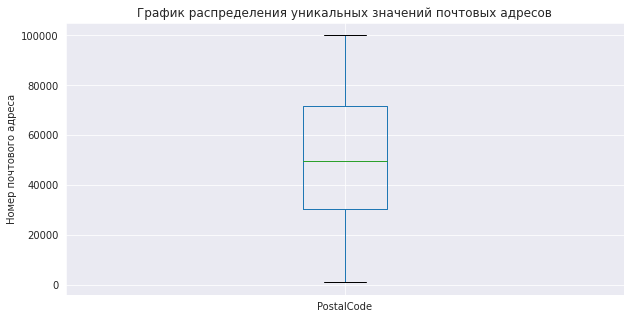

In [59]:
data.boxplot('PostalCode', figsize=(10,5))
plt.title('График распределения уникальных значений почтовых адресов')
plt.ylabel('Номер почтового адреса')
plt.xlabel('')
plt.show()

Распределение почтовых индексом говорит нам о том, что здесь нет необходимости что-либо корректировать. Проверив в интернете данные индексы, можно определить, что все они принадлежат Германии, для того чтобы достоверно определить местоположение собственника автомобиля достаточно двух первых цифр из пяти. В нашем случае, чтобы избежать большого количества категорий оставим от индекса только первую цифру.

In [60]:
data['PostalCode'] = data['PostalCode'].astype('str')
first_index = []
for word in np.array(data['PostalCode']):
    case_word = word[0]
    first_index.append(case_word)
data['Region'] = first_index
data['Region'] = data['Region'].astype('int')

In [61]:
data.head(2)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode,Region
0,480,other,1993,manual,75,golf,150000,0,petrol,volkswagen,2,70435,7
1,18300,coupe,2011,manual,190,undefined,125000,5,gasoline,audi,1,66954,6


In [62]:
del data['PostalCode']
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,Region
0,480,other,1993,manual,75,golf,150000,0,petrol,volkswagen,2,7
1,18300,coupe,2011,manual,190,undefined,125000,5,gasoline,audi,1,6
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,2,9
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0,9
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0,6


In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310578 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              310578 non-null  int64 
 1   VehicleType        310578 non-null  object
 2   RegistrationYear   310578 non-null  int64 
 3   Gearbox            310578 non-null  object
 4   Power              310578 non-null  int64 
 5   Model              310578 non-null  object
 6   Kilometer          310578 non-null  int64 
 7   RegistrationMonth  310578 non-null  int64 
 8   FuelType           310578 non-null  object
 9   Brand              310578 non-null  object
 10  Repaired           310578 non-null  int64 
 11  Region             310578 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 38.9+ MB


In [64]:
data.reset_index()
data['Price'] = pd.to_numeric(data['Price'], downcast='integer')
data['RegistrationYear'] = pd.to_numeric(data['RegistrationYear'], downcast='integer')
data['Power'] = pd.to_numeric(data['Power'], downcast='integer')
data['Kilometer'] = pd.to_numeric(data['Kilometer'], downcast='integer')
data['RegistrationMonth'] = pd.to_numeric(data['RegistrationMonth'], downcast='integer')
data['Repaired'] = pd.to_numeric(data['Repaired'], downcast='integer')
data['Region'] = pd.to_numeric(data['Region'], downcast='integer')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310578 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              310578 non-null  int16 
 1   VehicleType        310578 non-null  object
 2   RegistrationYear   310578 non-null  int16 
 3   Gearbox            310578 non-null  object
 4   Power              310578 non-null  int16 
 5   Model              310578 non-null  object
 6   Kilometer          310578 non-null  int32 
 7   RegistrationMonth  310578 non-null  int8  
 8   FuelType           310578 non-null  object
 9   Brand              310578 non-null  object
 10  Repaired           310578 non-null  int8  
 11  Region             310578 non-null  int8  
dtypes: int16(3), int32(1), int8(3), object(5)
memory usage: 26.1+ MB


In [65]:
del power_data

**Выводы**

В ходе предобработки данных, был изучен датасет на предмет выбросов в данных, наличия дубликатов и пропущенных значений.

* Автомобили с **ценой** ниже 10 евро в расчет не будут приниматься.
* Исходя из даты формирования объявления, отсечены значения **года регистрации** позже этой даты, в исследовании принято решение использовать автомобили не страше 67 лет.
* **Дата скачивания анкеты**, **дата создания анкеты**, **количество фотографий автомобиля**, **дата последней активности пользователя** удалены из набора данных.
* Отсутствующие значения в столбце **тип кузова** и **тип топлива** добавлены к категории 'other'.
* Строки с отсутствующими значения в столбце **тип коробки передач** удалены.
* У признака **мощность** выявлено 22 тычячи нулевых значений, их и можно считать пропусками. Мощность зачастую зависит от модели и года выпуска, данные заполнены исходя из имеющихся данных, значения для которых данных не хватило были удалены, скорректировы значения больше 340 (разделены на 100), меньше 15 (домножены на 10).
* Пустые значения признака **модель** выделены в отдельную категорию 'undefined'.
* У признаков **пробег** и **бренд** существенных аномалий не выявлено.
* Значение '0' у признака **месяц регистрации** в нашем случае принят за 'undefined'.
* Выявлен факт того, что в некоторых случаях нам неизвестно была ли **машина в ремонте**. Данный факт выделен в отдельную категорию, сам признак в количественный, где 0 будет отсутствие ремонта, 1 ремонт был и 2 - неопределено (таким образом можно будет определить вес каждой категории)
* **Почтовый индекс**. Определено, что все объявления были выставлены в Германии, для того чтобы достоверно определить местоположение собственника автомобиля достаточно двух первых цифр из пяти, но в нашем случае, чтобы избежать большого количества категорий оставим от индекса только первую цифру. Признак заменен на новый с названием **Region**


### Зависимость целевого признака

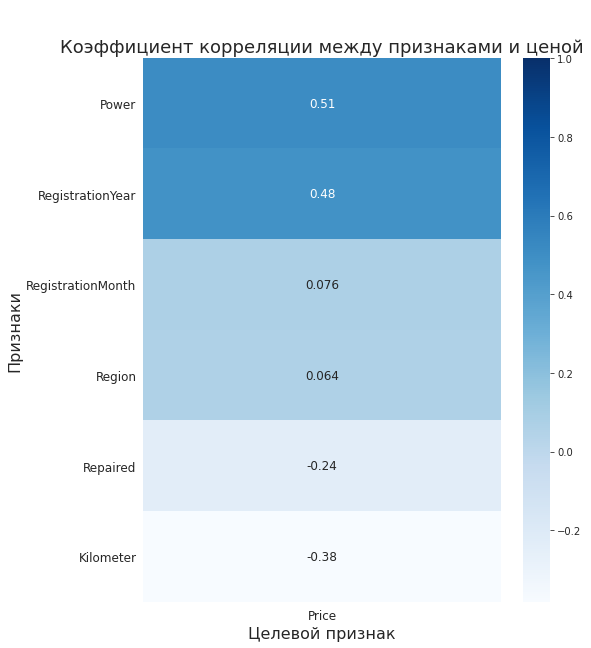

In [66]:
fig = plt.figure(figsize=(8,10))
ax = sns.heatmap(data.corr()[['Price']].sort_values('Price', ascending=False), annot = True, annot_kws = {"size":12}, cmap='Blues')
ax.set_title('Коэффициент корреляции между признаками и ценой', fontsize=18)
ax.set_xlabel('Целевой признак', fontsize = 16)
ax.set_ylabel('Признаки', fontsize = 16)
ax.tick_params(axis = "both", labelsize = 12);
y_min, y_max = ax.get_ylim()
ax.set_ylim(top=y_max+1)
plt.show()

Наблюдается сильная положительная корреляция стоимости от мощности и года регитстрации автомобиля, в то время как пробег имеет сильную отрицательную зависмость и так же сказывается на ценообразовании подержанного автомобиля.

## Обучение моделей

В этом пункте будут обучены разные модели. Для каждой будут подобраны оптимальные гиперпараметры и поставлен счётчик времени выполнения операций. Но перед этим необходимо применить кодирование текстовых данных и определить обучающую и тестовую выборку.

### Определение обучающей и тестовой выборки

Отделим целевой признак - Price — цена (евро) и определим обучающую и тестовую выборки в пропорции 75:25.

In [67]:
X = data.drop(columns='Price')
y = data['Price']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
print('Размер тренировочной выборки - {:.0%}'.format(X_train.shape[0]/X.shape[0]))
print('Размер тестовой выборки - {:.0%}'.format(X_test.shape[0]/y.shape[0]))

Размер тренировочной выборки - 75%
Размер тестовой выборки - 25%


### OrdinalEncoder

Разделим признаки на категориальные и числовые (месяц регистрации приняли за категорию из-за значение '0', которое в нашем случае это 'undefined')

In [69]:
category_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'RegistrationMonth']
numerical_features = ['RegistrationYear', 'Power', 'Kilometer', 'Repaired', 'Region']

Отделим целевой признак - Price — цена (евро), закодируем категориальные признаки и посмотрим на результат.

In [70]:
encoder = OrdinalEncoder()
encoder.fit(X_train[category_features])
X_train[category_features] = encoder.transform(X_train[category_features])
X_test[category_features] = encoder.transform(X_test[category_features])
X_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,Region
15771,7.00,2001,0.00,193,31.00,150000,3.00,6.00,1.00,1,3
339775,4.00,1986,1.00,55,166.00,30000,1.00,6.00,37.00,2,8
239586,7.00,2008,0.00,197,15.00,150000,12.00,2.00,2.00,0,5
127288,5.00,1995,1.00,60,102.00,150000,7.00,6.00,10.00,2,3
106484,1.00,2001,1.00,110,158.00,150000,10.00,6.00,19.00,0,6


In [71]:
print(X_train.isna().sum())

VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
Region               0
dtype: int64


### StandardScaler

Проведем масштабирование количественных признаков.

In [72]:
scaler = StandardScaler()

scaler.fit(X_train[numerical_features])
X_train[numerical_features] = scaler.transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print(X_train.shape)
print(X_test.shape)

X_train.head()

(232933, 11)
(77645, 11)


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,Region
15771,7.00,-0.27,0.00,1.45,31.00,0.58,3.00,6.00,1.00,0.78,-0.77
339775,4.00,-2.58,1.00,-1.25,166.00,-2.68,1.00,6.00,37.00,2.12,1.31
239586,7.00,0.81,0.00,1.53,15.00,0.58,12.00,2.00,2.00,-0.56,0.06
127288,5.00,-1.19,1.00,-1.15,102.00,0.58,7.00,6.00,10.00,2.12,-0.77
106484,1.00,-0.27,1.00,-0.17,158.00,0.58,10.00,6.00,19.00,-0.56,0.48


In [73]:
print(X_train.isna().sum())

VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
Region               0
dtype: int64


In [74]:
print(X_test.isna().sum())

VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
Region               0
dtype: int64


Категориальные признаки трансформированы в цифровой формат, а так же выборки разделены на обучающую и тестовую для проверки качества предсказания моделей. Количественные признаки отмасштабированы, можно переходить к обучению моделей и выбору лучшей, а так же оценки качества предсказания и скорости обучения.

 Для расчёта целевой метрики используем RMSE и напишем функцию.

In [75]:
def rmse(test,predict):
    return ((mse(test,predict))**0.5).round(2)

Cоздадим функцию, которая будет принимать на вход целевые и предсказанные значения, а возвращать абсолютное и среднеквадратичное отклонение на графиках с визульным распределением разброса целевых признаков.

In [76]:
def diagram(test,predict,grid):
    rmse = np.sqrt(-1 * grid.best_score_)
    #mae = mean_absolute_error(test,predict)
    plt.figure(figsize=(8, 5))
    pd.Series(predict).hist(bins=20, alpha=0.8)
    pd.Series(test).hist(bins=20, alpha=0.8)
    #plt.text(16122,11225,'MAE={:.2f}'.format(mae))
    plt.text(16122,10225,'RMSE={:.2f}'.format(rmse))
    plt.legend(['Предсказанные значения', 'Истинные значения'])
    plt.title('График распределения предсказанных и истинных значениий', y=1.05)
    plt.xlabel('Предсказанные / Истинные значения')
    plt.ylabel('Количество')
    plt.subplot()
    
    plt.figure(figsize=(8, 8))
    plt.plot(predict,test,'o', alpha=0.5)
    plt.xlim(-5000,25000)
    plt.ylim(-5000,25000)
    plt.plot([-10000,25000],[-10000,25000],'--y', linewidth=2)
    plt.title('График отношения предсказанных значений к истинным значениям', y=1.05)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.show()

Нам также интересно узнать насколько важны те или иные параметры моделей, для этого будем использовать **feature importance**.

In [77]:
def importance(model,features):
    features = features.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(figsize=(11, 5))
    plt.title('Важность функции')
    plt.barh(range(len(indices)), importances[indices], color='#6495ED', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Относительная важность')
    plt.show()
        
    feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)
    feat_importances = feat_importances.to_frame()
    feat_importances.columns=['Относительная важность']
    display(feat_importances)

### Ridge Regression

In [78]:
pipe_ridge = Pipeline([
    ('model', Ridge(random_state=RANDOM_STATE))
])

params = [
    {
        'model__alpha': np.logspace(-2, 3, 20)
    } 
]

In [79]:
grid_ridge = GridSearchCV(pipe_ridge,
                    param_grid=params,
                    cv=3,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    verbose=False)

In [80]:
%%time
grid_ridge.fit(X_train, y_train)

CPU times: user 5.23 s, sys: 5.11 s, total: 10.3 s
Wall time: 10.3 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('model', Ridge(random_state=12345))]),
             n_jobs=-1,
             param_grid=[{'model__alpha': array([1.00000000e-02, 1.83298071e-02, 3.35981829e-02, 6.15848211e-02,
       1.12883789e-01, 2.06913808e-01, 3.79269019e-01, 6.95192796e-01,
       1.27427499e+00, 2.33572147e+00, 4.28133240e+00, 7.84759970e+00,
       1.43844989e+01, 2.63665090e+01, 4.83293024e+01, 8.85866790e+01,
       1.62377674e+02, 2.97635144e+02, 5.45559478e+02, 1.00000000e+03])}],
             scoring='neg_mean_squared_error', verbose=False)

In [81]:
grid_ridge.best_params_

{'model__alpha': 26.366508987303583}

In [82]:
%%time
predict_ridge = grid_ridge.predict(X_test)

CPU times: user 36.8 ms, sys: 44.1 ms, total: 80.9 ms
Wall time: 89 ms


Показатели предсказания модели Ridge Regressor

In [83]:
ridge_rmse = np.sqrt(-1 * grid_ridge.best_score_)
print('RMSE модели Ridge Regression равна:', ridge_rmse.round(2))

RMSE модели Ridge Regression равна: 2975.18


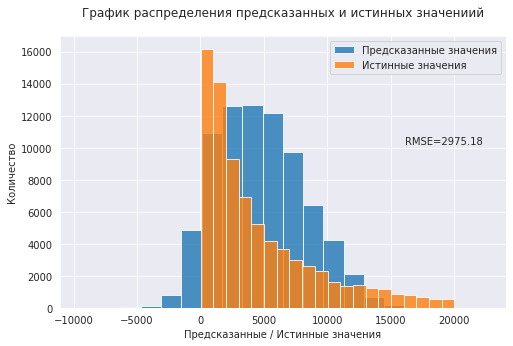

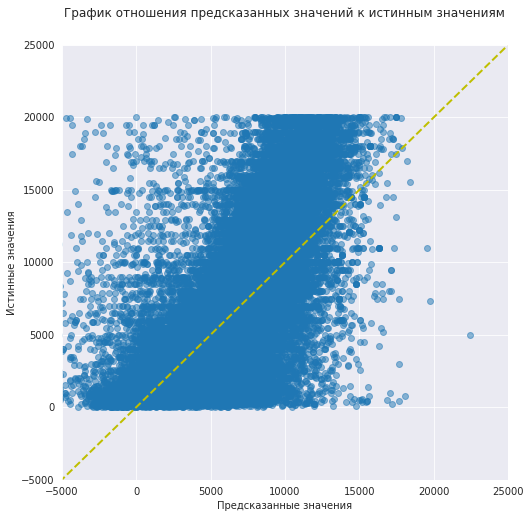

In [84]:
diagram(y_test, predict_ridge, grid_ridge)

Для модели Ridge Regression факторы важности **feature importance** отсутствуют, из-за того, что модель проста и не предполагает ветвление деревьев.

In [85]:
start = time.time()
best_model_ridge = Ridge(random_state=RANDOM_STATE, alpha = 26.366508987303583)
best_model_ridge.fit(X_train, y_train)
end = time.time()
time_ridge = round(end-start,2)

In [86]:
start = time.time()
predict_ridge = best_model_ridge.predict(X_test)
end = time.time()
time_ridge_predict = round(end-start,2)

### RandomForestRegressor

In [87]:
params = [
    {
        'n_estimators': range(5,11,5),
        'max_depth': range(90,101,5),
    } 
]
model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

In [88]:
grid_rf = GridSearchCV(model_rf,
                    param_grid=params,
                    cv=3,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,  
                    verbose=False)

In [89]:
%%time
grid_rf.fit(X_train, y_train)

CPU times: user 1min 38s, sys: 951 ms, total: 1min 39s
Wall time: 1min 40s


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=12345),
             n_jobs=-1,
             param_grid=[{'max_depth': range(90, 101, 5),
                          'n_estimators': range(5, 11, 5)}],
             scoring='neg_mean_squared_error', verbose=False)

In [90]:
grid_rf.best_params_

{'max_depth': 90, 'n_estimators': 10}

In [91]:
%%time
predict_rf = grid_rf.predict(X_test)

CPU times: user 461 ms, sys: 0 ns, total: 461 ms
Wall time: 476 ms


Показатели предсказания модели RandomForestRegressor

In [92]:
rf_rmse = np.sqrt(-1 * grid_rf.best_score_)
print('RMSE модели RandomForestRegressor равна:', rf_rmse.round(2))

RMSE модели RandomForestRegressor равна: 1705.31


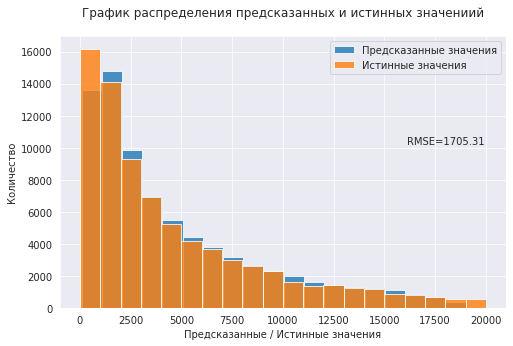

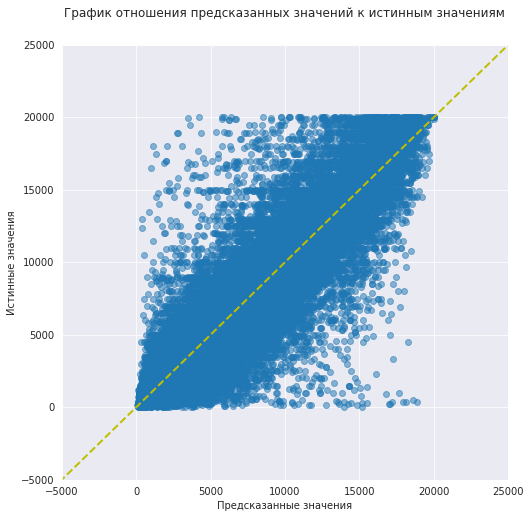

In [93]:
diagram(y_test, predict_rf, grid_rf)

Значимость признаков модели RandomForestRegressor

In [94]:
start = time.time()
best_model_rf = RandomForestRegressor(random_state=RANDOM_STATE, max_depth=90, n_estimators=10)
best_model_rf.fit(X_train, y_train)
end = time.time()
time_rf = round(end-start,2)

In [95]:
start = time.time()
predict_rf = best_model_rf.predict(X_test)
end = time.time()
time_rf_predict = round(end-start,2)

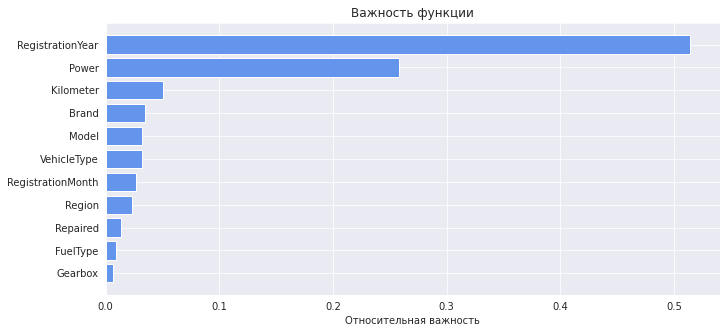

,Относительная важность
RegistrationYear,0.51
Power,0.26
Kilometer,0.05
Brand,0.03
Model,0.03
VehicleType,0.03
RegistrationMonth,0.03
Region,0.02
Repaired,0.01
FuelType,0.01


In [96]:
importance(best_model_rf, X_test)

### CatBoostRegressor

In [97]:
params = [
    {
        'learning_rate': [0.4, 0.5],
        'n_estimators': [1000]
    } 
]
model_catboost = CatBoostRegressor(random_state=RANDOM_STATE, verbose=100)

In [98]:
grid_catboost = GridSearchCV(model_catboost,
                    param_grid=params,
                    cv=3,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,  
                    verbose=100)

In [99]:
%%time
grid_catboost.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3; 1/2] START learning_rate=0.4, n_estimators=1000........................
0:	learn: 3501.4224607	total: 91.6ms	remaining: 1m 31s
100:	learn: 1633.3437385	total: 2.98s	remaining: 26.5s
200:	learn: 1547.6970905	total: 5.91s	remaining: 23.5s
300:	learn: 1494.3404456	total: 9.24s	remaining: 21.5s
400:	learn: 1456.7363898	total: 12s	remaining: 17.9s
500:	learn: 1424.1347722	total: 14.7s	remaining: 14.7s
600:	learn: 1398.7609145	total: 17.2s	remaining: 11.4s
700:	learn: 1375.1809753	total: 19.9s	remaining: 8.5s
800:	learn: 1355.8208885	total: 22.8s	remaining: 5.66s
900:	learn: 1339.6667571	total: 25.5s	remaining: 2.8s
999:	learn: 1323.7372084	total: 28.1s	remaining: 0us
[CV 1/3; 1/2] END ......learning_rate=0.4, n_estimators=1000; total time=  30.2s
[CV 2/3; 1/2] START learning_rate=0.4, n_estimators=1000........................
0:	learn: 3484.6458600	total: 41.7ms	remaining: 41.6s
100:	learn: 1639.4555832	total: 2.9s	remainin

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f7158717970>,
             n_jobs=-1,
             param_grid=[{'learning_rate': [0.4, 0.5], 'n_estimators': [1000]}],
             scoring='neg_mean_squared_error', verbose=100)

In [100]:
grid_catboost.best_params_

{'learning_rate': 0.4, 'n_estimators': 1000}

In [101]:
%%time
predict_catboost = grid_catboost.predict(X_test)

CPU times: user 96.4 ms, sys: 0 ns, total: 96.4 ms
Wall time: 99 ms


Показатели предсказания модели CatBoostRegressor

In [102]:
catboost_rmse = np.sqrt(-1 * grid_catboost.best_score_)
print('RMSE модели CatBoostRegressor равна:', catboost_rmse.round(2))

RMSE модели CatBoostRegressor равна: 1576.63


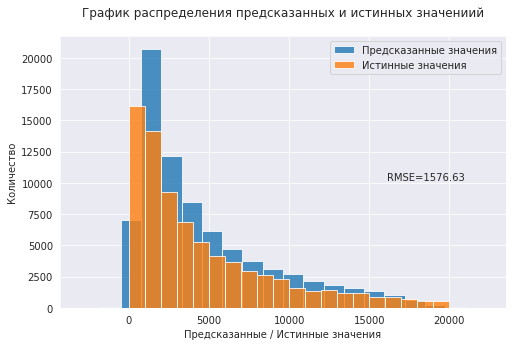

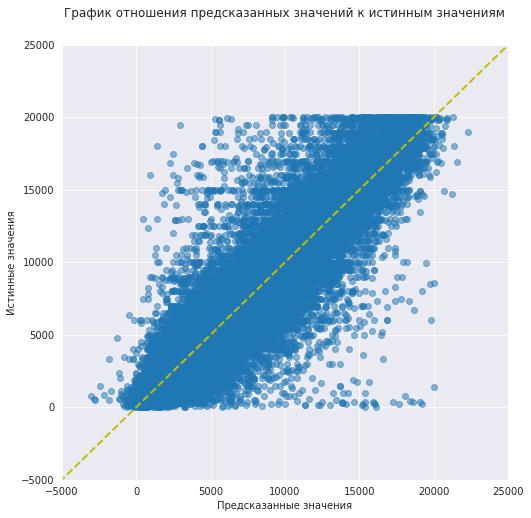

In [103]:
diagram(y_test, predict_catboost, grid_catboost)

Значимость признаков модели CatBoostRegressor

In [104]:
start = time.time()
best_model_catboost = CatBoostRegressor(random_state=RANDOM_STATE, verbose=100, learning_rate=0.4, n_estimators=1000)
best_model_catboost.fit(X_train, y_train)
end = time.time()
time_catboost = round(end-start,2)

0:	learn: 3501.6513721	total: 54.3ms	remaining: 54.2s
100:	learn: 1640.7390190	total: 4.33s	remaining: 38.5s
200:	learn: 1563.6208333	total: 8.28s	remaining: 32.9s
300:	learn: 1515.9455265	total: 12.3s	remaining: 28.5s
400:	learn: 1480.5622302	total: 16.3s	remaining: 24.3s
500:	learn: 1450.5213376	total: 20.2s	remaining: 20.1s
600:	learn: 1427.0563083	total: 24.2s	remaining: 16.1s
700:	learn: 1407.9069333	total: 27.9s	remaining: 11.9s
800:	learn: 1390.5203801	total: 31.8s	remaining: 7.89s
900:	learn: 1374.6805849	total: 36.1s	remaining: 3.96s
999:	learn: 1360.5393568	total: 40s	remaining: 0us


In [105]:
start = time.time()
predict_catboost = best_model_catboost.predict(X_test)
end = time.time()
time_catboost_predict = round(end-start,2)

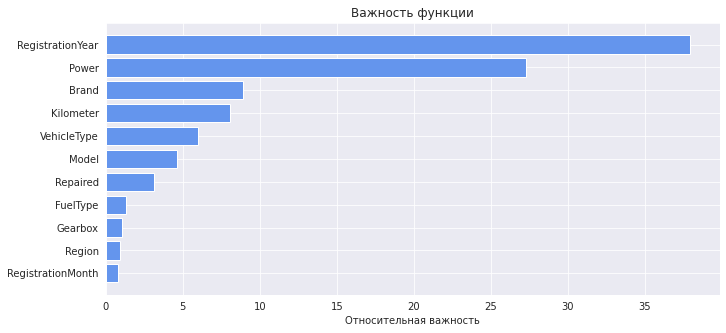

,Относительная важность
RegistrationYear,37.95
Power,27.28
Brand,8.92
Kilometer,8.05
VehicleType,5.98
Model,4.66
Repaired,3.11
FuelType,1.34
Gearbox,1.04
Region,0.90


In [106]:
importance(best_model_catboost, X_test)

### LightGBMRegressor

In [108]:
params = [
    {
           'learning_rate': [0.4],
           'n_estimators': [60]
    } 
]
model_lgbm = LGBMRegressor(boosting_type='gbdt', random_state=RANDOM_STATE, verbose=10, force_row_wise=True)

In [109]:
grid_lgbm = GridSearchCV(model_lgbm,
                    param_grid=params,
                    cv=2,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,  
                    verbose=100)

In [110]:
%%time
grid_lgbm.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START learning_rate=0.4, n_estimators=60..........................
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.155168
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 116466, number of used features: 11
[LightGBM] [Info] Start training from score 4756.816994
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [D

GridSearchCV(cv=2,
             estimator=LGBMRegressor(force_row_wise=True, random_state=12345,
                                     verbose=10),
             n_jobs=-1,
             param_grid=[{'learning_rate': [0.4], 'n_estimators': [60]}],
             scoring='neg_mean_squared_error', verbose=100)

In [111]:
grid_lgbm.best_params_

{'learning_rate': 0.4, 'n_estimators': 60}

In [112]:
%%time
predict_lgbm = grid_lgbm.predict(X_test)

CPU times: user 328 ms, sys: 0 ns, total: 328 ms
Wall time: 365 ms


Показатели предсказания модели LightGBMRegressor

In [113]:
lgbm_rmse = np.sqrt(-1 * grid_lgbm.best_score_)
print('RMSE модели LightGBMRegressor равна:', lgbm_rmse.round(2))

RMSE модели LightGBMRegressor равна: 1674.21


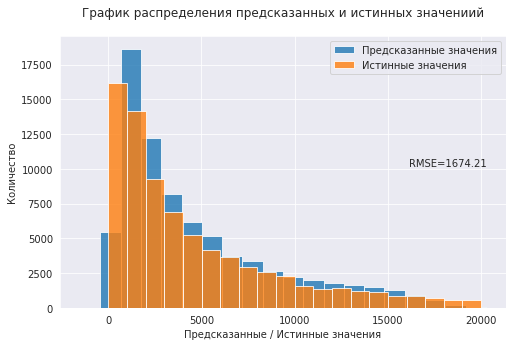

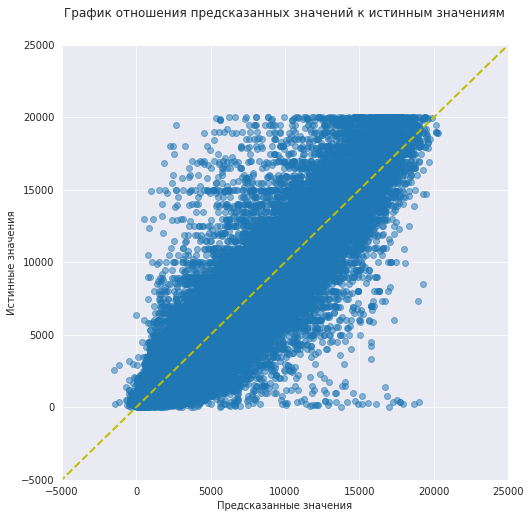

In [114]:
diagram(y_test, predict_lgbm, grid_lgbm)

Значимость признаков модели LightGBMRegressor

In [115]:
start = time.time()
best_model_lgbm = LGBMRegressor(random_state=RANDOM_STATE, n_estimators=60, learning_rate=0.4, objective='rmse')
best_model_lgbm.fit(X_train, y_train)
end = time.time()
time_lgbm = round(end-start,2)

In [116]:
%%time
start = time.time()
predict_lgbm = best_model_lgbm.predict(X_test)
end = time.time()
time_lgbm_predict = round(end-start,2)

CPU times: user 322 ms, sys: 0 ns, total: 322 ms
Wall time: 294 ms


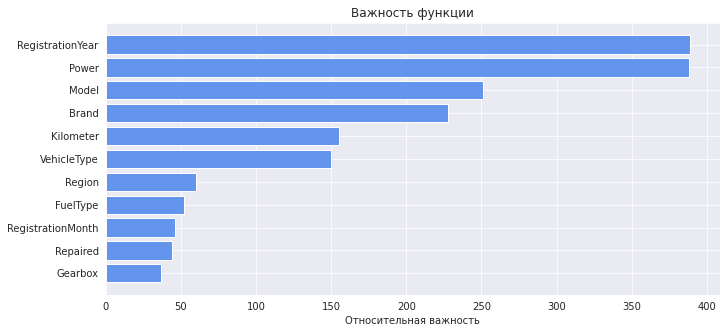

,Относительная важность
RegistrationYear,389
Power,388
Model,251
Brand,228
Kilometer,155
VehicleType,150
Region,60
FuelType,52
RegistrationMonth,46
Repaired,44


In [117]:
importance(best_model_lgbm, X_test)

**Выводы**

В ходе обучения моделей, категориальные признаки были закодированы **OrdinalEncoder**, проведено масштабирование количественных признаков. Размер тренировочной выборки - 75%. Размер тестовой выборки - 25%.

По качеству предсказания на метрике MAE и распределению значений на графиках лучше всех себя показала модель RandomForestRegressor, в то время как модель CatBoost показала лучший результат по метрике RMSE, у LGBM в отличии от двух других моделей значимость признака - год регистрации (RegistrationYear) занимает второе место уступив мощности Power), а вот модель RidgeRegression оказалась совсем не точной, но в тоже время быстрой.


## Анализ моделей

Проанализируем скорость работы и качество моделей. Для наглядности сведём все интересующие нас данные в таблицу.

In [118]:
column=['RMSE модели','Скорость обучения, сек','Скорость предсказания, сек']

comparison_table = pd.DataFrame(index=['RMSE модели','Скорость обучения, сек', 'Скорость предсказания, сек'], columns=['RidgeRegression','RandomForestRegressor','CatBoostRegressor','LightGBM'])
comparison_table['RidgeRegression'] = ridge_rmse, time_ridge, time_ridge_predict
comparison_table['RandomForestRegressor'] = rf_rmse, time_rf, time_rf_predict
comparison_table['CatBoostRegressor'] = catboost_rmse, time_catboost, time_catboost_predict
comparison_table['LightGBM'] = lgbm_rmse, time_lgbm, time_lgbm_predict

comparison_table.T.style.highlight_min(color='yellowgreen',subset=column).highlight_null(null_color='lightgrey').highlight_max(color='coral',subset=column)


,RMSE модели,"Скорость обучения, сек","Скорость предсказания, сек"
RidgeRegression,2975.180958,0.030000,0.020000
RandomForestRegressor,1705.305106,10.420000,0.510000
CatBoostRegressor,1576.630135,42.350000,0.140000
LightGBM,1674.212636,236.840000,0.290000


### Тестирование лучшей модели

В качестве лучшей модели, которая удовлетворяет всем условиям заказчика рекомендуется использовать CatBoostRegressor, со следующими гиперпараметрами:

CatBoostRegressor(random_state=RANDOM_STATE, verbose=100, learning_rate=0.4, n_estimators=1000)


In [119]:
catboost_best_rmse = rmse(y_test, predict_catboost)
print('RMSE модели Ridge Regression равна:', catboost_best_rmse.round(2))

RMSE модели Ridge Regression равна: 1564.1


In [120]:
model_scores = pd.DataFrame(data=[
            ('СatBoostRegressor', catboost_rmse, catboost_best_rmse, time_catboost, time_catboost_predict)], 
            columns=['Рекомендуемая модель', 'RMSE на обучающей выборке', 'RMSE на тестовой выборке', 'Скорость обучения, сек', 'Скорость предсказания, сек'])
model_scores = model_scores.style.hide_index()
model_scores   

Рекомендуемая модель,RMSE на обучающей выборке,RMSE на тестовой выборке,"Скорость обучения, сек","Скорость предсказания, сек"
СatBoostRegressor,1576.630135,1564.100000,42.350000,0.140000


**Вывод**

Для оценки качества моделей применялась метрика RMSE и MAE.
Значение метрики RMSE должно было получиться меньше 2500, данное значение достигнуто для всех моделей кроме линейной регресии. Модель LightGBMRegressor и CatBoostRegressor была построена с помощью градиентного бустинга.

Задача проекта - построить модель для определения стоимости автомобиля, с лучшими показателями качества предсказания, скорости и времени обучения. Чем ниже RMSE, тем лучше данная модель может «соответствовать» набору данных.

Технология градиетного бустинга сравнивалась с базовыми моделями RidgeRegression и RandomForestRegressor

По итогам обучения моделей на тестовых данных - с небольшим отрывом модель **CatBoostRegressor** показала лучший результат - **1576,63**, однако этот результат был достигнут затратив большее время на обучение предсказаний нежели, например, у случайного леса - **48** секунд. На тестовых данных результат RMSE схож = **1564,10**

В вашем распоряжении исторические данные компании "Не бит, не крашен": технические характеристики, комплектации и цены автомобилей. Рекомендуется строить модель для определения стоимости с помощью **CatBoostRegressor** со следующими гиперпараметрами **learning_rate=0.4**, **n_estimators=1000**, скорость обучения и выдачи предсказаний достаточно высокая, при небольшом расхождении показателей по качеству предсказания (**RMSE 1674.21**) от **LightGBM**, скорость решает.
